In [10]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch
import torchvision
from torchvision import transforms, models
import cv2
from torchvision import transforms as T
import random

### Video to Frames

In [7]:
vidcap = cv2.VideoCapture('./query.mp4')

count = 0

while(vidcap.isOpened()): 
    ret, image = vidcap.read() # 이미지 사이즈 960x540으로 변경 
    image = cv2.resize(image, (960, 540)) # 30프레임당 하나씩 이미지 추출 
    
    if(int(vidcap.get(1)) % 30 == 0): 
        #print('Saved frame number : ' + str(int(vidcap.get(1)))) 
        # 추출된 이미지가 저장되는 경로 
        cv2.imwrite("./frames/frame%d.png" % count, image) 
        #print('Saved frame%d.jpg' % count) 
        if count == 890:
            break
        count += 1

vidcap.release()

### MaskRCNN pretrained model import

In [8]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [9]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [11]:
def get_prediction(img_path, threshold=0.5, url=False):
    if url: # We have to request the image
        response = requests.get(img_path)
        img = Image.open(BytesIO(response.content))
    else:
        img = Image.open(img_path) # This is for local images
    transform = T.Compose([T.ToTensor()]) # Turn the image into a torch.tensor
    img = transform(img)
    #img = img.cuda() # Only if GPU, otherwise comment this line
    pred = model([img]) # Send the image to the model. This runs on CPU, so its going to take time
    #Let's change it to GPU
    # pred = pred.cpu() # We will just send predictions back to CPU
    # Now we need to extract the bounding boxes and masks
    pred_score = list(pred[0]['scores'].detach().cpu().numpy())
    pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1]
    masks = (pred[0]['masks'] > 0.5).squeeze().detach().cpu().numpy()
    pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].cpu().numpy())]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().cpu().numpy())]
    masks = masks[:pred_t+1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    
    return masks, pred_boxes, pred_class

In [288]:
def instance_segmentation(img_path, threshold=0.5, rect_th=3,
                          text_size=3, text_th=3, url=False):
    masks, boxes, pred_cls = get_prediction(img_path, threshold=threshold, url=url)
    #print(pred_cls)
    if url:
        img = url_to_image(img_path) # If we have a url image
    else: # Local image
        img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # For working with RGB images instead of BGR
    for i in range(len(masks)):
        if pred_cls[i] == 'person': 
            rgb_mask = random_color_masks(masks[i])
            img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
            mask_list.append(masks[i])
            box_list.append(boxes[i])
    return img, mask_list

In [291]:
def contour_drawing(img, contour_list):
    query_img = img.copy()

    for i in range(len(contour_list)):
        cv2.drawContours(query_img, contour_list[i], -1, (255,255,255), 7)
    return query_img

In [303]:
def masking(query, mask):
    mask = mask.astype(float)
    _, alpha = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY)
    
    alpha = cv2.GaussianBlur(alpha, (7, 7), 0).astype(float)
    
    alpha = alpha / 255. # (height, width)
    alpha = np.repeat(np.expand_dims(alpha, axis=2), 3, axis=2) # (height, width, 3)
    #query = query.copy()
    #query = cv2.multiply(0, query.astype(float))
    foreground = cv2.multiply(alpha, query.astype(float))
    
    #fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    #axes[0].imshow(mask)
    #axes[1].imshow(foreground.astype(np.uint8))
    
    return foreground.astype(np.uint8)

In [304]:
def Auto_Resizer(target, background) :
    target_size = target.shape
    background_size = background.shape
    resized_background = cv2.resize(background, dsize = (target.shape[1], target.shape[0]), interpolation = cv2.INTER_CUBIC)
    return resized_background

In [40]:
#frame number 바꿔가면서 오류 발생하는지 아닌지 판별
mask_list = []
box_list = []
img, pred_classes, masks = instance_segmentation('./frames/frame0.png', rect_th=5, text_th=4)

['person', 'person', 'tie', 'person', 'person']


In [286]:
query = cv2.imread('./frames/frame189.png')
_, masks = instance_segmentation('./frames/frame189.png')

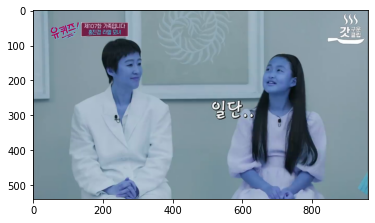

In [305]:
plt.imshow(query)

## 여기서 코드 실행!

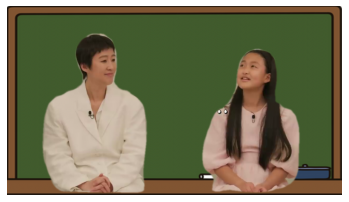

In [342]:
mask_list = []
box_list = []

img = cv2.imread('./frames/frame189.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
_, masks = instance_segmentation('./frames/frame189.png')

background = Auto_Resizer(img, cv2.imread('back.png'))
background = cv2.cvtColor(background, cv2.COLOR_BGR2RGB)



mask_img = []
contour_list = []
for i in range(len(masks)):
    img2 =  np.zeros_like(img)
    img2[:,:,0] = mask_list[i]*255
    img2[:,:,1] = mask_list[i]*255
    img2[:,:,2] = mask_list[i]*255
    mask_img.append(img2)
    
    imgray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(imgray, 0, 255, 0)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contour_list.append(contours)
    
for mask in mask_list:
    mask = mask.astype(float)
    _, alpha = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY)
    alpha = cv2.GaussianBlur(alpha, (7, 7), 0).astype(float)
    alpha = alpha / 255. # (height, width)
    alpha = np.repeat(np.expand_dims(alpha, axis=2), 3, axis=2)
    background = cv2.multiply(1.0-alpha, background.astype(float))

background = background/255

for i in range(len(mask_list)):
    if i == 0:
        new = masking(img, mask_list[0])
    else :
        new = new + masking(img, mask_list[i])

        
#new = contour_drawing(new/255+background, contour_list)
new = new/255+background
plt.axis('off')
plt.imshow(new)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


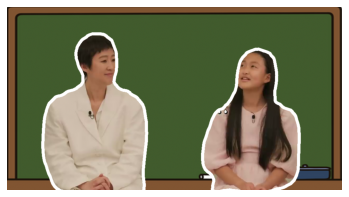

In [325]:
plt.axis('off')
plt.imshow(new[:525,:])
plt.savefig('savefig_default.png')

In [326]:
for mask in mask_list:
    mask = mask.astype(float)
    _, alpha = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY)
    alpha = cv2.GaussianBlur(alpha, (7, 7), 0).astype(float)
    alpha = alpha / 255. # (height, width)
    alpha = np.repeat(np.expand_dims(alpha, axis=2), 3, axis=2)
    background = cv2.multiply(1.0-alpha, background.astype(float))

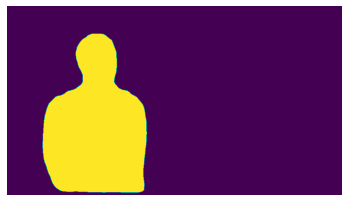

In [337]:
plt.axis('off')
plt.imshow(mask_list[0])

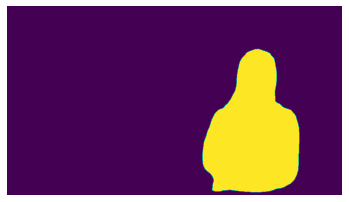

In [338]:
plt.axis('off')
plt.imshow(mask_list[1])

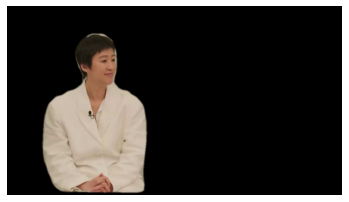

In [339]:
plt.axis('off')
plt.imshow(masking(img, mask_list[0]))

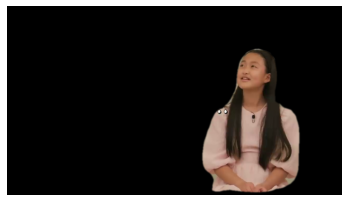

In [340]:
plt.axis('off')
plt.imshow(masking(img, mask_list[1]))

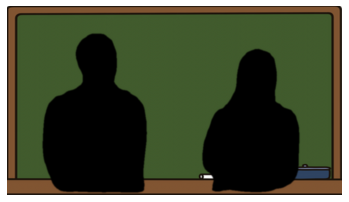

In [341]:
plt.axis('off')
plt.imshow(background)